### Import lib

In [1]:
import os
os.chdir("/cerea_raid/users/dumontj/dev/coco2/dl")
import numpy as np
import sys
import tensorflow as tf
from tensorflow import keras
import keras.backend as K
import matplotlib.pyplot as plt
import models.seg as sm

### Loss functions

In [2]:
def pixel_weighted_cross_entropy(y_true, y_pred):
    y_bin_true = tf.cast(y_true > 0, y_true.dtype)
    loss_val = keras.losses.binary_crossentropy(y_bin_true, y_pred)
    weights = tf.where(y_true > 0, y_true, 1.)
    loss_val = tf.convert_to_tensor(tf.squeeze(weights), np.float32)*loss_val
    return K.mean(loss_val)

### Data generation

In [3]:
# general param
N_img = 10_000
Ny = 32
Nx = 32
y, x = np.indices((Ny,Nx))

# data
magni = np.random.uniform(0.2, 3, N_img).reshape(1,1,-1)
center_Y = np.random.uniform(0,Ny, N_img).reshape(1,1,-1)
center_X = np.random.uniform(0,Nx, N_img).reshape(1,1,-1)
var_Y = np.random.uniform(0,20, N_img).reshape(1,1,-1)
var_X = np.random.uniform(0,20, N_img).reshape(1,1,-1)

data = magni * np.exp(-0.5*((np.expand_dims(x, axis=-1)-center_X)**2/var_X 
                            + (np.expand_dims(y, axis=-1)-center_Y)**2/var_Y))
data = np.where(data>0, data, 0)
# noise
noise = np.random.normal(0, 1, size=(N_img, Ny,Nx))


# datasets
data = np.transpose(data, (2,0,1))
data_X = (data + noise).reshape(N_img,Ny,Nx,1).astype(np.float32)
data_X = np.where(data_X>0, data_X, 0)

bin_data_Y = np.where(data.reshape(N_img,Ny,Nx,1)>0.1, 1., 0.).astype(np.float32)
reg_data_Y = np.where(data.reshape(N_img,Ny,Nx,1)>0.1, data.reshape(N_img,Ny,Nx,1), 0.).astype(np.float32)

data_Y = reg_data_Y

ratio_train = 0.8
train_X = data_X[:int(ratio_train*N_img)]
train_Y = data_Y[:int(ratio_train*N_img)]
test_X = data_X[int(ratio_train*N_img):]
test_Y = data_Y[int(ratio_train*N_img):]


In [4]:
test_Y.shape

(2000, 32, 32, 1)

### Model def

In [5]:
model = sm.Unet_2([Ny, Nx, 1], 1)
model.compile('adam', loss=pixel_weighted_cross_entropy)
#model.compile("adam", loss=tf.keras.losses.binary_crossentropy)

2022-06-21 17:18:01.601963: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-21 17:18:02.095699: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13797 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:3b:00.0, compute capability: 7.5


### Training

In [6]:
model.fit(x=train_X, y=train_Y, epochs=15, validation_data=(test_X, test_Y))

Epoch 1/15


2022-06-21 17:18:04.310969: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8202
2022-06-21 17:18:04.845297: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


250/250 [==============================] - 9s 22ms/step - loss: 0.0658 - val_loss: 0.0454
Epoch 2/15
250/250 [==============================] - 5s 19ms/step - loss: 0.0444 - val_loss: 0.0434
Epoch 3/15
250/250 [==============================] - 5s 18ms/step - loss: 0.0413 - val_loss: 0.0398
Epoch 4/15
250/250 [==============================] - 5s 19ms/step - loss: 0.0392 - val_loss: 0.0378
Epoch 5/15
250/250 [==============================] - 5s 18ms/step - loss: 0.0385 - val_loss: 0.0373
Epoch 6/15
250/250 [==============================] - 5s 19ms/step - loss: 0.0380 - val_loss: 0.0394
Epoch 7/15
250/250 [==============================] - 5s 19ms/step - loss: 0.0371 - val_loss: 0.0365
Epoch 8/15
250/250 [==============================] - 5s 19ms/step - loss: 0.0366 - val_loss: 0.0373
Epoch 9/15
250/250 [==============================] - 5s 20ms/step - loss: 0.0362 - val_loss: 0.0377
Epoch 10/15
250/250 [==============================] - 5s 19ms/step - loss: 0.0360 - val_loss: 0.0371


### Evaluation

In [14]:
np.squeeze(model(tf.expand_dims(test_X[idx], 0))[0]).shape

(32, 32)

Text(0.5, 1.0, 'image')

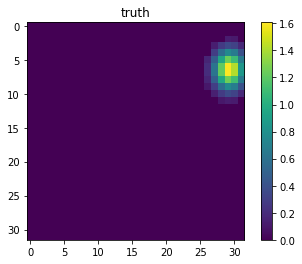

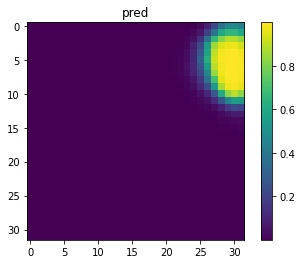

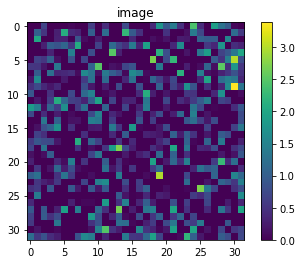

In [15]:
idx = int(np.random.uniform(0,N_img*0.2))
plt.figure()
plt.imshow(np.squeeze(test_Y[idx]))
plt.colorbar()
plt.title("truth")
plt.figure()
plt.imshow(np.squeeze(model(tf.expand_dims(test_X[idx], 0))))
plt.colorbar()
plt.title("pred")
plt.figure()
plt.imshow(np.squeeze(test_X[idx]))
plt.colorbar()
plt.title("image")